In [1]:
import pandas as pd
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# Inputs

In [2]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'

# Case study dates
# start_date = '20221101'; end_date = '20230312'
# start_date = '20221031'; end_date = '20221103'
start_date = '20230218'; end_date = '20230224'
# start_date = '20230129'; end_date = '20230204'
# start_date = '20230131'; end_date = '20230204'
# start_date = '20230204'; end_date = '20230208'
# start_date = '20230217'; end_date = '20230221'
# start_date = '20230310'; end_date = '20230314'
# start_date = '20230314'; end_date = '20230320'

In [7]:
df = pd.read_parquet('../sos/tidy_df_30Min_20221201_20230501_planar_fit.parquet')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time').loc[start_date:end_date].reset_index()

# Plot time series

In [8]:
temp_chart = alt.Chart().transform_filter(
    alt.FieldOneOfPredicate('variable', ['Tsurf_c', 'Tsurf_d', 'Tsurf_ue', 'Tsurf_uw', 'T_2m_c'])
).transform_window(
    rolling_mean = 'mean(value)',
    frame = [-6, 6],
    groupby = ['variable']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", title='Temperature (˚C)'),
    alt.Color("variable:N")
).properties(width=800, height=400)

In [9]:
w_h2o_chart = alt.Chart().transform_filter(
    alt.FieldOneOfPredicate('tower', ['c'])
).transform_filter(
    alt.FieldOneOfPredicate('measurement', ['w_h2o_'])
).mark_line().transform_window(
    rolling_mean='median(value)',
    frame=[-10, 10],
    groupby=['variable']
).encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", 
    # scale=alt.Scale(domain=[-0.1, 0.1], clamp=True, nice=False), 
    title='Latent Heat Flux (g/m^2)'),
    alt.Color("height:O", scale=alt.Scale(scheme='viridis'))
).properties(width=800, height=200)

In [10]:
wind_speed_chart = alt.Chart().transform_filter(
    alt.FieldOneOfPredicate('variable', ['spd_2m_c', 'spd_3m_c'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Wind Speed (m/s)'),
    alt.Color("variable:N")
).properties(width=800, height=200)

In [11]:
richardson_chart = alt.Chart().transform_filter(
    alt.FieldOneOfPredicate('variable', ['Ri_2m_c', 'Ri_rad_2m_c'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Richardson Number'),
    alt.Color("variable:N")
).properties(width=800, height=200)

In [12]:
tke_chart = alt.Chart().transform_filter(
    alt.datum.variable == 'tke_2m_c'
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='TKE', scale=alt.Scale(type='log')),
    alt.Color("variable:N")
).properties(width=800, height=200)

In [13]:
model_chart = alt.Chart().transform_filter(
    alt.datum.height == 2
).transform_filter(
    alt.FieldOneOfPredicate('measurement', [
        'w_h2o_', 
        'w_h2o_ modeled Standard',
        'w_h2o_ modeled MO (Holtslag/de Bruin)', 
    ])
).transform_window(
    rolling_mean='mean(value)',
    frame=[-6, 6],
    groupby=['measurement']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", title='Latent Heat Flux (g/m^2)'),
    alt.Color("measurement:N")
).properties(width=800, height=150)

In [14]:
snow_flux_chart = alt.Chart().transform_filter(
    alt.FieldOneOfPredicate('measurement', ['snow flux'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Blowing Snow Flux (g/m^2)'),
    alt.Color("height:N")
).properties(width=800, height=200)

In [15]:
chart = alt.VConcatChart(
    data = df,
    vconcat = [
        wind_speed_chart.properties(height=150), 
        temp_chart.properties(height=150), 
        richardson_chart.properties(height=150), 
        tke_chart.properties(height=150), 
        w_h2o_chart.properties(height=150), 
        snow_flux_chart.properties(height=150)
    ]
).resolve_scale(color='independent', x='shared').configure_legend(
    labelLimit = 0
)

chart

alt.VConcatChart(...)

# Compare surface temperature measurements

## Plot the snow temperature measurements to find closest in-snow measurement to surface

In [16]:
alt.Chart(df).transform_filter(
    alt.datum.measurement == 'snow temperature'
).transform_filter(
    # alt.datum.height > 0.7
    alt.datum.height > 0.0
).transform_window(
    rolling_mean='mean(value)',
    frame=[-6,6],
    groupby=['height']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", title="Temperature (˚C, 30min rolling avg)"),
    alt.Color("height:N"),
    alt.Facet("tower:N", columns=1)
).properties(width=900, height=280, title='Temperatures from Tower D in-snow thermistor array')

alt.Chart(...)

Looks like the 1.1 thermistor is closest to the snow surface and the 1.2 thermistor is just above the snow surface.

## Plot temperature gradients close to the surface

We have air temperature measurements on tower d above 1.1. We can use the air temp measurements at 1.2, 1.3, 1.4, and 1.5 to extend the temperature profile on tower c. Note that the snow height measurements need to be adjusted. We can also adjust the tower c temperature measurements. We know the snow depth is somewhere between 1.1 and 1.2m, let's use 1.1 to reset the measurement heights of the temperature data.

In [20]:
temps_df = pd.concat([
    df.query("tower == 'd'").query("measurement == 'snow temperature'").query("height > 1.1").assign(height = df['height'] - 1.1),
    df.query("measurement == 'temperature'").assign(height = df['height'] - 1.1),
    df.query("tower == 'd'").query("variable == 'Tsurf_rad_d'")
])

In [27]:
temps_df['time'].dt.day.unique()

array([18, 19, 20, 21, 22, 23, 24])

In [28]:
src = temps_df[temps_df['time'].dt.day == 19][temps_df['time'].dt.minute == 0]
src['hour'] = src['time'].dt.hour
src['day_quarter'] = pd.cut(src['hour'], 4, labels = [1,2,3,4])

/tmp/ipykernel_36606/2469744038.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = temps_df[temps_df['time'].dt.day == 19][temps_df['time'].dt.minute == 0]


In [29]:
alt.Chart(
    src
).mark_line(strokeWidth=2).encode(
    alt.X("value:Q", sort='-y', title='Temperature (˚C)'),
    alt.Y("height", title='Height (m)').scale(type='linear', clamp=True),
    alt.Color("hour:O").scale(scheme='viridis'),
    alt.Facet("day_quarter:O", columns=2, title=None).header(labelFontSize=0),
).resolve_scale(
    x='independent',
    color='independent'
).properties(
    title = str(src.time.iloc[0].date()),
    width = 250,
    height = 250
)

alt.Chart(...)

In [30]:

alt.Chart(
    src
).transform_filter(
    alt.datum.height <= 1
).mark_line(point=True, strokeWidth=1).encode(
    alt.X("value:Q", sort='-y', title='Temperature (˚C)'),
    alt.Y("height", title='Height (m)').scale(type='linear', clamp=True),
    alt.Color("hour:O").scale(scheme='viridis'),
    alt.Facet("day_quarter:O", columns=2, title=None).header(labelFontSize=0),
    alt.Shape("measurement").scale(range=['triangle', 'cross', 'circle'])
).resolve_scale(
    x='independent',
    color='independent'
).configure_point(
    size=100
).properties(
    title = str(src.time.iloc[0].date()),
    width = 250,
    height = 250
)

alt.Chart(...)

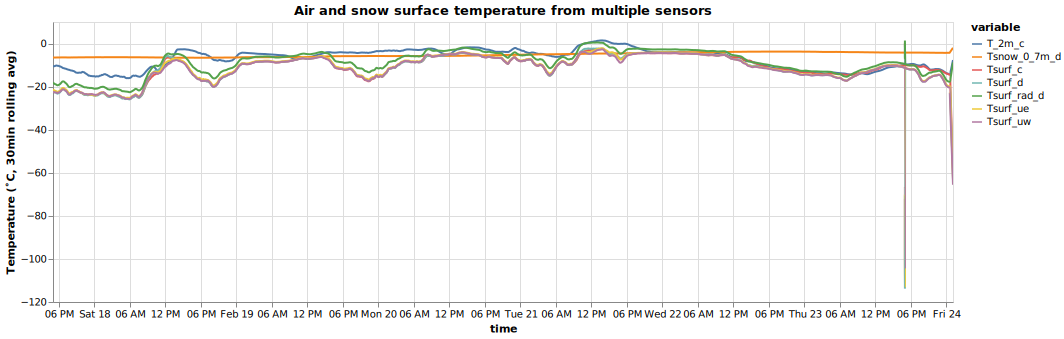

In [20]:
alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('variable', ['Tsurf_c', 'Tsurf_d', 'Tsurf_ue', 'Tsurf_uw', 'Tsnow_0_7m_d', 'T_2m_c', 'Tsurf_rad_d'])
).transform_window(
    rolling_mean='mean(value)',
    frame=[-6,6],
    groupby=['variable']
).mark_line(interpolate='monotone').encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", title="Temperature (˚C, 30min rolling avg)"),
    alt.Color("variable:N"),
    # alt.Color("height:N"),
    # alt.StrokeDash("measurement:N")
).properties(width=900, height=280, title="Air and snow surface temperature from multiple sensors").interactive()

# Calc Ri and heat fluxes with turbpy using multiple surf. temp. measurements

In [21]:
# get turby schemes
stab_titles, stab_methods, stab_dict = sosutils.get_turbpy_schemes()

for surf_temp_col in ['Tsurf_c', 'Tsurf_d', 'Tsurf_ue', 'Tsurf_uw', 'Tsurf_rad_d']:
    
    RiBulk = sosutils.tidy_df_calculate_richardson_number_with_turbpy(
        tidy_df_30Min,
        tower = 'c',
        height = 2,    
        snowDepth = 1,
        pressure_height = 10,
        fillna_method = 'ffill',
        surface_temp_col_substitute = surf_temp_col
    )

    tidy_df_30Min = sosutils.tidy_df_add_variable(
        tidy_df_30Min,
        RiBulk,
        f'Ri_2m_c_{surf_temp_col}',
        f'Richardson Number using {surf_temp_col}',
        2,
        'c'
    )


    # run models and get results
    (
        stability_correction,
        conductance_sensible,
        conductance_latent,
        sensible_heat,
        latent_heat,
        zeta
    ) = sosutils.tidy_df_model_heat_fluxes_with_turbpy(
        tidy_df_30Min,
        stab_titles, 
        stab_methods,
        stab_dict,
        'c', 
        2, 
        1,
        10, 
        fillna_method='ffill',
        surface_temp_col_substitute = surf_temp_col
    )

    # heat fluxes and the following calculations:
    # *  vertical water vapor moisture flux (m/s * g/m^2) using the latent heat of sublimation
    # Note that we use the opposite convention of turbpy - latent and sensible heat fluxes should be positive upward
    # therefore there are negative signs below
    for stab in stab_titles:
        tidy_df_30Min = sosutils.tidy_df_add_variable(
            tidy_df_30Min,
            - latent_heat[stab],
            f'LH_modeled_{stab}_2m_c_{surf_temp_col}',
            f'latent heat flux modeled {stab} using {surf_temp_col}',
            2,
            'c'
        )
        tidy_df_30Min = sosutils.tidy_df_add_variable(
            tidy_df_30Min,
            - latent_heat[stab]/(2838),
            f'w_h20_modeled_{stab}_2m_c_{surf_temp_col}',
            f'w_h2o_ modeled {stab} using {surf_temp_col}',
            2,
            'c'
        )
        tidy_df_30Min = sosutils.tidy_df_add_variable(
            tidy_df_30Min,
            - latent_heat[stab]/(2838),
            f'SH_modeled_{stab}_2m_c_{surf_temp_col}',
            'sensible heat flux modeled {stab} using {surf_temp_col}',
            2,
            'c'
        )

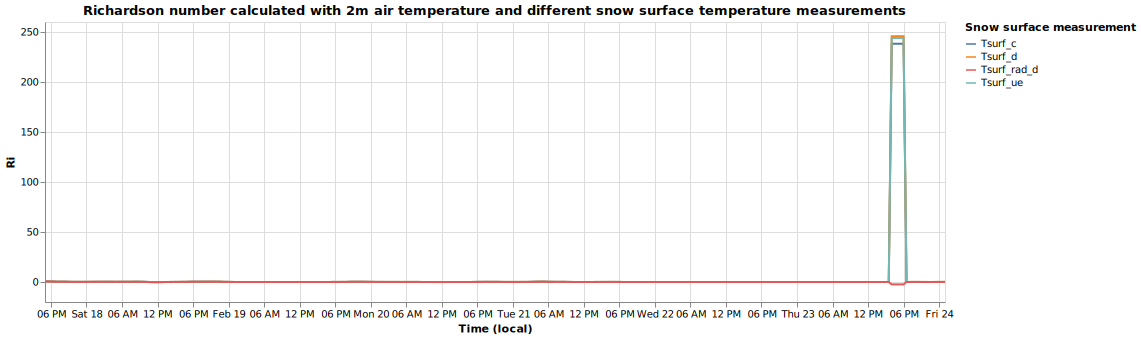

In [24]:
column_dict = {
    'Richardson Number using Tsurf_c': 'Tsurf_c',
    'Richardson Number using Tsurf_d': 'Tsurf_d',
    'Richardson Number using Tsurf_ue': 'Tsurf_ue',
    'Richardson Number using Tsurf_rad_d': 'Tsurf_rad_d',
}
src = tidy_df_30Min[tidy_df_30Min.measurement.isin(column_dict.keys())]
src['plot_name'] = src['measurement'].apply(column_dict.get)

snow_surface_plot = alt.Chart(src).transform_window(
    rolling_mean = 'mean(value)',
    frame=[-2, 2],
    groupby=['plot_name']
).mark_line().encode(
    alt.X("time:T", title='Time (local)'),
    alt.Y("rolling_mean:Q", title='Ri'),
    alt.Color("plot_name:N", title='Snow surface measurement')
).properties(width=900, height=280, title='Richardson number calculated with 2m air temperature and different snow surface temperature measurements')
snow_surface_plot

In [25]:
tidy_df_10Min = pd.DataFrame(
    tidy_df.set_index('time').groupby(
        ['measurement', 'variable', 'height', 'tower']
    )['value'].resample('10Min').median()
).reset_index()

WARN Conflicting  property "width" (1000 and 900). Using 1000.
WARN Conflicting  property "height" (300 and 280). Using 300.
WARN Infinite extent for field "time": [Infinity, -Infinity]
WARN Infinite extent for field "rolling_mean": [Infinity, -Infinity]


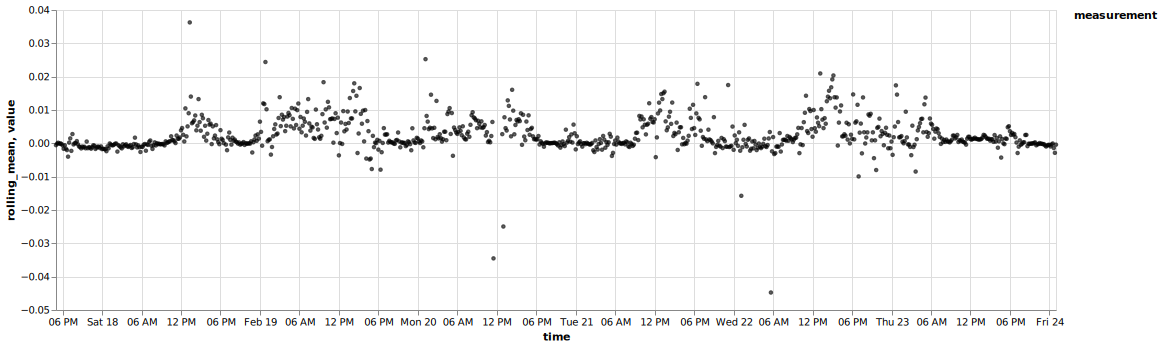

In [26]:
(alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate(
        'variable',
        [
            'w_h20_modeled_Standard_2m_c_Tsurf_c',
            'w_h20_modeled_Standard_2m_c_Tsurf_d',
            'w_h20_modeled_Standard_2m_c_Tsurf_ue',
            'w_h20_modeled_Standard_2m_c_Tsnow_0_7m_d',
            'w_h20_modeled_Standard_2m_c_Tsurf_rad_d',
        ]
    )
).transform_window(
    rolling_mean = 'mean(value)',
    frame=[-2, 2],
    groupby=['measurement']
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("rolling_mean:Q"),
    alt.Color("measurement")
).properties(width=1000, height=300) + \
\
alt.Chart(tidy_df_10Min).transform_filter(
    alt.FieldOneOfPredicate('variable',['w_h2o__2m_c'])
).mark_point(color='black', size=6).encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
).properties(width=900, height=280)).configure_legend(
    labelLimit = 0
)

In [ ]:
[f for f in tidy_df.variable.unique() if f.startswith('w_h20_')]

In [ ]:
model_df = tidy_df[tidy_df['variable'].isin([
    'w_h2o__2m_c',
    'w_h20_modeled_Standard_2m_c',
    'w_h20_modeled_MO (Holtslag/de Bruin)_2m_c',
    'Ri_2m_c'
])].pivot_table(index=['time', 'tower', 'height'], values='value', columns='variable').reset_index()

In [ ]:
model_df[['w_h2o__2m_c', 'w_h20_modeled_Standard_2m_c']]

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

sns.scatterplot(
    model_df,
    x='w_h2o__2m_c',
    y='w_h20_modeled_Standard_2m_c',
    # s=10,
    alpha=0.05,
    ax=axes[0]
)
r2 = r2_score(
    model_df.dropna()['w_h2o__2m_c'], 
    model_df.dropna()['w_h20_modeled_Standard_2m_c']
)
axes[0].set_title("R2: {:.2f}".format(r2))

sns.scatterplot(
    model_df,
    x='w_h2o__2m_c',
    y='w_h20_modeled_MO (Holtslag/de Bruin)_2m_c',
    # s=10,
    alpha=0.05,
    ax=axes[1]
)
r2 = r2_score(
    model_df.dropna()['w_h2o__2m_c'], 
    model_df.dropna()['w_h20_modeled_MO (Holtslag/de Bruin)_2m_c']
)
axes[1].set_title("R2: {:.2f}".format(r2))

# Compare TKE and temperature gradient

In [ ]:
tidy_df = sosutils.tidy_df_add_variable(
        tidy_df,
        tidy_df.query("variable == 'T_2m_c'").value.values - tidy_df.query("variable == 'Tsurf_rad_d'").value.values,
        f'temperature gradient',
        'temperature gradient',
        2,
        'c'
    )

In [ ]:
model_df = tidy_df[tidy_df['variable'].isin([
    'temperature gradient',
    'tke_2m_c',
    'spd_2m_c'
])].pivot_table(index=['time', 'tower', 'height'], values='value', columns='variable').reset_index()

In [ ]:
sns.scatterplot(model_df, x='spd_2m_c', y='tke_2m_c')

In [ ]:
sns.scatterplot(model_df, x='temperature gradient', y='tke_2m_c')

# At multiple heights and towers - Calculate Richardson number and modeled heat fluxes with turbpy and add new variables to our tidy df

In [ ]:
# get turby schemes

SNOW_DEPTH = 1
PRESSURE_HEIGHT = 10

for tower in ['c']:
    for height in [2,3,5,10,20]:

        stab_titles, stab_methods, stab_dict = sosutils.get_turbpy_schemes()

        RiBulk = sosutils.tidy_df_calculate_richardson_number_with_turbpy(
            tidy_df,
            tower = tower,
            height = height,    
            snowDepth = SNOW_DEPTH,
            pressure_height = PRESSURE_HEIGHT
        )

        # run models and get results
        (
            stability_correction,
            conductance_sensible,
            conductance_latent,
            sensible_heat,
            latent_heat,
            zeta
        ) = sosutils.tidy_df_model_heat_fluxes_with_turbpy(
            tidy_df,
            stab_titles, 
            stab_methods,
            stab_dict,
            tower, 
            height, 
            SNOW_DEPTH,
            PRESSURE_HEIGHT
        )

        # combine results into tidy_df and calculate:
        # richardson number
        tidy_df = sosutils.tidy_df_add_variable(
            tidy_df,
            RiBulk,
            f'Ri_{height}m_{tower}',
            'Richardson Number',
            height,
            tower
        )

        # heat fluxes and the following calculations:
        # *  vertical water vapor moisture flux (m/s * g/m^2) using the latent heat of sublimation
        # Note that we use the opposite convention of turbpy - latent and sensible heat fluxes should be positive upward
        # therefore there are negative signs below
        for stab in stab_titles:
            tidy_df = sosutils.tidy_df_add_variable(
                tidy_df,
                - latent_heat[stab],
                f'LH_modeled_{stab}_{height}m_{tower}',
                f'latent heat flux modeled {stab}',
                height,
                tower
            )
            tidy_df = sosutils.tidy_df_add_variable(
                tidy_df,
                - latent_heat[stab]/(2838),
                f'w_h20_modeled_{stab}_{height}m_{tower}',
                f'w_h2o_ modeled {stab}',
                height,
                tower
            )
            tidy_df = sosutils.tidy_df_add_variable(
                tidy_df,
                - latent_heat[stab]/(2838),
                f'SH_modeled_{stab}_{height}m_{tower}',
                'sensible heat flux modeled {stab}',
                height,
                tower
            )

In [ ]:
temp_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('variable', ['Tsurf_c', 'T_2m_c', 'T_3m_c', 'T_5m_c', 'T_10m_c', 'T_20m_c'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color("variable:N")
).properties(width=1200, height=150)

In [ ]:
w_h2o_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('measurement', ['w_h2o_'])
).mark_line().transform_window(
    rolling_mean='mean(value)',
    frame=[-10, 10],
    groupby=['variable']
).encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", scale=alt.Scale(domain=[-0.1, 0.1], clamp=True, nice=False)),
    alt.Color("height:O", scale=alt.Scale(scheme='viridis'))
).properties(width=1200, height=150)

In [ ]:
wind_speed_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('variable', ['spd_2m_c', 'spd_3m_c', 'spd_5m_c', 'spd_10m_c', 'spd_20m_c'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color("variable:N")
).properties(width=1200, height=150)

In [ ]:
richardson_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('variable', ['Ri_2m_c', 'Ri_3m_c', 'Ri_5m_c', 'Ri_10m_c', 'Ri_2m0_c'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color("variable:N")
).properties(width=1200, height=150)

In [ ]:
model_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('height', [2,3,5,10,20])
).transform_filter(
    alt.FieldOneOfPredicate('measurement', [
        'w_h2o_', 
        'w_h2o_ modeled Standard',
        'w_h2o_ modeled MO (Holtslag/de Bruin)', 
    ])
).transform_window(
    rolling_mean='mean(value)',
    frame=[-6, 6],
    groupby=['measurement']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", ),
    alt.Color("measurement:N"),
    alt.Facet("height:O", columns=1)
).properties(width=1200, height=150).resolve_scale(y='independent')

In [ ]:
(wind_speed_chart & temp_chart & w_h2o_chart & richardson_chart & model_chart).resolve_scale(color='independent', x='shared')

In [ ]:
column_dict = {
    'w_h20_modeled_MO (Holtslag/de Bruin)_2m_c_Tsurf_c': 'Tsurf_c',
    'w_h20_modeled_MO (Holtslag/de Bruin)_2m_c_Tsurf_d': 'Tsurf_d',
    'w_h20_modeled_MO (Holtslag/de Bruin)_2m_c_Tsurf_ue': 'Tsurf_ue',
    'w_h20_modeled_MO (Holtslag/de Bruin)_2m_c_Tsnow_1_1m_d': 'Tsnow_1_1m_d',
    'w_h20_modeled_MO (Holtslag/de Bruin)_2m_c_Tsurf_rad_d': 'Tsurf_rad_d',
}
src = tidy_df[tidy_df.variable.isin(column_dict.keys())]
src['plot_name'] = src['variable'].apply(column_dict.get)


temp_plot & \
\
snow_surface_plot & \
\
alt.Chart(src).transform_window(
    rolling_mean = 'mean(value)',
    frame=[-2, 2],
    groupby=['measurement']
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("rolling_mean:Q"),
    alt.Color("plot_name:N", title='Snow surface measurement')
).properties(width=900, height=280) + \
\
alt.Chart(tidy_df_10Min).transform_filter(
    alt.FieldOneOfPredicate('variable',['w_h2o__2m_c'])
).mark_point(color='black', size=6).encode(
    alt.X("time:T", title='Time (local)'),
    alt.Y("value:Q", title='Vertical moisture flux (g/m^2/s)'),
).properties(width=900, height=280, title='Estimates of vertical moisture flux using different snow surface measurements')
